## Import Libraries

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from scipy import signal
import mne

In [132]:
data_path = '../../../data/ssvep_test_1.csv'
eeg_data = pd.read_csv(data_path)

## Clean & Batch EEG Data

In [222]:
channels = ["Fz_filt","C3_filt","Cz_filt","C4_filt","Pz_filt","PO7_filt","Oz_filt","PO8_filt"]

data = eeg_data[channels].to_numpy()
labels = eeg_data["filled_stim"].to_numpy()

In [219]:
def preprocess(data, sfreq):
# Filter Data Bandpass .5-200 Hz 
    filt = mne.filter.filter_data(data, sfreq, 0.5, 40,method="iir")

    # # Notch filter at 60 Hz and its harmonics (up to 300 Hz) with a stopband of 2 Hz
    # notch_freqs = np.arange(60, 301, 60)

    # for notchfreq in notch_freqs:
    #     filt = mne.filter.notch_filter(filt, sfreq,notchfreq, method="iir")
    
    return filt

In [223]:
data = preprocess(data, 250)

Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB



In [225]:
def batch_array(arr, batch_size=250):
    return np.array_split(arr, np.ceil(len(arr) / batch_size))

In [226]:
batched_data = batch_array(data)
batched_labels = batch_array(labels)

## Create reference signals and calculate correlation

In [227]:
def create_reference_signals(freq, harmonics, sample_rate, num_samples):
    t = np.arange(num_samples) / sample_rate
    references = []
    for h in range(1, harmonics + 1):
        references.append(np.sin(2 * np.pi * freq * h * t))
        references.append(np.cos(2 * np.pi * freq * h * t))
    return np.array(references).T

In [228]:
def detect_ssvep(eeg_data, sample_rate, target_freqs, harmonics=2):
    num_samples = eeg_data.shape[0]
    correlations = []

    for freq in target_freqs:
        references = create_reference_signals(freq, harmonics, sample_rate, num_samples)
        cca = CCA(n_components=1)
        cca.fit(eeg_data, references)
        correlations.append(cca.score(eeg_data, references))

    detected_freq = target_freqs[np.argmax(correlations)]
    return detected_freq, correlations

In [237]:
sample_rate = 250  # Hz
target_freqs = [7, 21]  # Hz

batched_correlations = []

for data in batched_data:
    _, correlations = detect_ssvep(data, sample_rate, target_freqs)

    batched_correlations.append(correlations)

batched_correlations = np.array(batched_correlations)

In [238]:
batched_correlations

array([[2.29485075e-09, 2.21307431e-09],
       [2.64476030e-06, 1.86056440e-06],
       [1.17104842e-06, 1.98814374e-06],
       [2.93257775e-05, 4.57401546e-06],
       [2.63973095e-06, 2.43891263e-05],
       [3.54264218e-06, 5.05890907e-06],
       [5.15018024e-07, 6.18912252e-07],
       [2.32015294e-06, 5.64028240e-06],
       [2.77201293e-05, 8.26913529e-06],
       [1.89843695e-06, 5.19809427e-06],
       [9.22436616e-07, 1.10481071e-06],
       [4.43308185e-06, 1.16564638e-06],
       [1.94721686e-06, 2.85957060e-06],
       [2.75938649e-05, 9.83460501e-06],
       [3.26969976e-05, 8.24416288e-07],
       [2.40645933e-06, 1.84348252e-05],
       [5.19844177e-06, 1.38458105e-06],
       [9.07152870e-06, 1.44488611e-06],
       [3.96471881e-05, 1.04991179e-06],
       [2.35254722e-06, 7.35313338e-05],
       [2.91808274e-06, 2.77648548e-06],
       [1.24829648e-06, 5.31798566e-06],
       [1.38597401e-06, 2.06480006e-06],
       [1.20896817e-06, 1.23035906e-06],
       [7.523387

In [259]:
batched_predictions = []

# seven_hz_threshold = 1e-7
# twentyone_hz_threshold = 1e-7
threshold = 5e-6

for correlations in batched_correlations:
    if np.max(correlations) > threshold:
        batched_predictions.append(np.argmax(correlations) + 1)
    # if correlations[0] > seven_hz_threshold:
    #     batched_predictions.append(1)
    # elif correlations[1] > twentyone_hz_threshold:
    #     batched_predictions.append(2)
    else:
        batched_predictions.append(0) # No SSVEP detected 

batched_predictions = np.array(batched_predictions)

## Assess accuracy

In [250]:
from scipy.stats import mode

labels_avg = []

for labels in batched_labels:
    labels_avg.append(int(mode(labels).mode))

labels_avg = np.array(labels_avg)

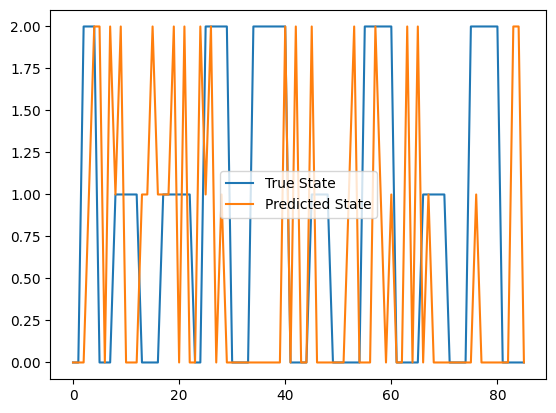

In [260]:
plt.plot(labels_avg, label="True State")
plt.plot(batched_predictions, label="Predicted State")
plt.legend()

In [261]:
np.mean(labels_avg == batched_predictions)

0.38372093023255816